In [1]:
%matplotlib inline
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

import pickle

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

import itertools

import matplotlib.pyplot as plt

# The ordering must be channels_last, so I set image_dim_ordering accordingly
# NHWC or 'last channel' format is expected by X-CUBE-AI
# https://community.st.com/s/question/0D50X0000APZ3t8SQD/invalid-network-and-not-implemented-input-size-smaller-than-filter-kernel-is-not-handled-error-in-log
K.set_image_dim_ordering('tf')

C:\Users\c.dicaprio\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [pixels][width][height].
In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [3]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][pixels]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

As before, it is a good idea to normalize the pixel values to the range 0 and 1 and one hot encode the output variables.

In [4]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Next we define our neural network model.
Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.
1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

In [5]:
def baseline_model():
 # create model
 model = Sequential()
 model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(0.2))
 model.add(Flatten())
 model.add(Dense(128, activation='relu'))
 model.add(Dense(num_classes, activation='softmax'))
 # Compile model
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

We evaluate the model the same way as before with the multi-layer perceptron. The CNN is fit over 10 epochs with a batch size of 200.

In [6]:
# build the model
model = baseline_model()
# Fit the model
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 42s - loss: 0.2235 - acc: 0.9362 - val_loss: 0.0749 - val_acc: 0.9768
Epoch 2/10
 - 40s - loss: 0.0710 - acc: 0.9782 - val_loss: 0.0467 - val_acc: 0.9849
Epoch 3/10
 - 41s - loss: 0.0504 - acc: 0.9845 - val_loss: 0.0427 - val_acc: 0.9862
Epoch 4/10
 - 41s - loss: 0.0402 - acc: 0.9874 - val_loss: 0.0394 - val_acc: 0.9871
Epoch 5/10
 - 40s - loss: 0.0321 - acc: 0.9902 - val_loss: 0.0347 - val_acc: 0.9887
Epoch 6/10
 - 40s - loss: 0.0261 - acc: 0.9919 - val_loss: 0.0330 - val_acc: 0.9904
Epoch 7/10
 - 40s - loss: 0.0224 - acc: 0.9927 - val_loss: 0.0347 - val_acc: 0.9892
Epoch 8/10
 - 40s - loss: 0.0195 - acc: 0.9936 - val_loss: 0.0328 - val_acc: 0.9890
Epoch 9/10
 - 40s - loss: 0.0163 - acc: 0.9948 - val_loss: 0.0309 - val_acc: 0.9895
Epoch 10/10
 - 41s - loss: 0.0131 - acc: 0.9959 - val_loss: 0.0301 - val_acc: 0.9910
CNN Error: 0.90%


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


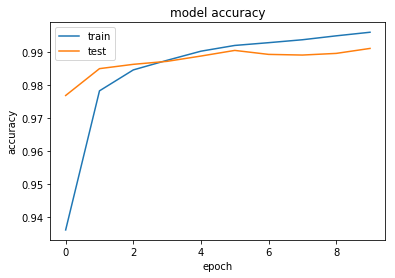

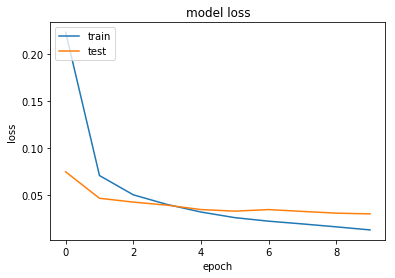

In [7]:
#
axes = plt.gca()

# set x label range
r = numpy.arange(0,10)

# list all data in history
print(h.history.keys())
# summarize history for accuracy
plt.plot(r, h.history['acc'])
plt.plot(r, h.history['val_acc'])
plt.title("model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(32,224)
plt.show()

# summarize history for loss
plt.plot(r, h.history['loss'])
plt.plot(r, h.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(32,224)
plt.show()

In [8]:
# save the model
model.save("Mnist_Keras2.h5")
# save corresponding training history
with open("Mnist_Keras2_history.pkl","wb") as f:
 pickle.dump(h, f)

TypeError: can't pickle _thread.RLock objects

In [9]:
# Print out model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
_________________________________________________________________


In [10]:
#
preds = model.predict_classes(X_test)

In [11]:
# Funtion to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')#


In [12]:
test_labels = y_test
# https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
test_labels = numpy.argmax(test_labels, axis=1)
cnf_matrix = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[ 978    0    0    1    0    0    0    0    1    0]
 [   0 1132    1    1    0    0    0    0    1    0]
 [   4    3 1016    0    2    0    0    5    2    0]
 [   0    0    1 1004    0    2    0    0    3    0]
 [   0    0    0    0  975    0    0    0    0    7]
 [   2    0    0    5    0  884    1    0    0    0]
 [   6    2    0    1    2    3  941    0    3    0]
 [   0    0    5    1    0    0    0 1021    1    0]
 [   4    0    1    1    0    1    0    1  964    2]
 [   0    1    0    1    4    3    0    2    3  995]]
Normalized confusion matrix
[[9.98e-01 0.00e+00 0.00e+00 1.02e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.02e-03 0.00e+00]
 [0.00e+00 9.97e-01 8.81e-04 8.81e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  8.81e-04 0.00e+00]
 [3.88e-03 2.91e-03 9.84e-01 0.00e+00 1.94e-03 0.00e+00 0.00e+00 4.84e-03
  1.94e-03 0.00e+00]
 [0.00e+00 0.00e+00 9.90e-04 9.94e-01 0.00e+00 1.98e-03 0.00e+00 0.00e+00
  2.97e-03 0.00e+00]
 [0.00e+00 0.00e+00 0

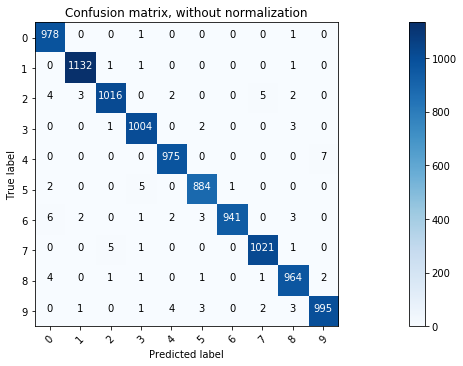

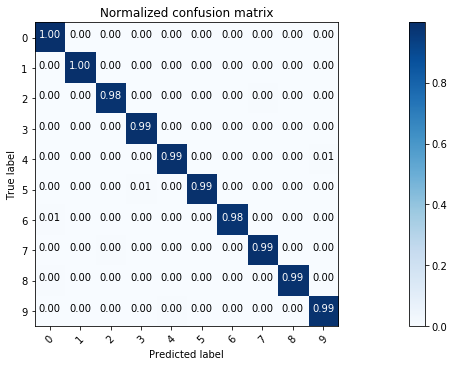

In [13]:
#
class_names = [i for i in range(10)]
numpy.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()